In [1]:
import json
import torch
import seaborn
import pylab as mpl
import matplotlib.pyplot as plt
from kt_base_model import get_kt_batch, KT, KTData
from ec_geo_model import get_ec_batch, EC, ECData
from kt_ec_mtl_train import Trainer

mpl.rcParams['font.sans-serif'] = ['DengXian']  
mpl.rcParams['axes.unicode_minus'] = False

print('torch.__version__: ', torch.__version__)
print('cuda.__version__: ', torch.version.cuda)
print(torch.cuda.is_available())

torch.__version__:  1.7.0+cu110
cuda.__version__:  11.0
True


In [2]:
n_question = 8
n_pid = 1500
seq_len = 30
n_blocks = 1
mid_size = 64
d_model = 128
dropout = 0.05
epoch_num = 150

lr_ec = 1.5e-4
lr_kt = 2e-4
bs_ec = 16 
bs_kt = 16 
l2_ec = 1e-4
l2_kt = 2e-4
max_grad_norm = -1

In [3]:
name_dict = {'array': 0, 'hash-table': 1, 'math': 2, 'string': 3,
             'dynamic-programming': 4, 'greedy': 5, 'sorting': 6, 'depth-first-search': 7}

In [4]:
with open('./problem_data_a.json', 'r', encoding='utf8')as fp:
    data = json.load(fp)
with open('glove.6B.50d.txt', 'rb') as f:
    lines = f.readlines()
print('exer_num', len(data))

exer_num 1500


In [5]:
trained_dict = dict()
for i in range(len(lines)):
    line = lines[i].split()
    trained_dict[line[0].decode("utf-8").upper()] = [float(line[j]) for j in range(1, 51)]

In [6]:
glove = ECData(data=data, name_dict=name_dict, trained_dict=trained_dict, 
               train_path='./ec_train_data.json', test_path='./ec_test_data.json')
glove.get_words()
glove.get_id()

In [7]:
train_ec = get_ec_batch(glove.train_content, glove.train_y, bs_ec)
test_ec = get_ec_batch(glove.test_content, glove.test_y, bs_ec)
print('train_ec', len(train_ec), ', test_ec', len(test_ec))
print('test_rate', len(test_ec) / (len(test_ec) + len(train_ec)))

train_ec 81 , test_ec 12
test_rate 0.12903225806451613


In [8]:
data = KTData(n_question=n_question, seq_len=seq_len)
data.load_data('./exercise_data_a.txt', train_path='./kt_train_data.txt', test_path='./kt_test_data.txt')

In [9]:
train_kt = get_kt_batch(data.q_train, data.qa_train, data.p_train, bs_kt)
test_kt = get_kt_batch(data.q_test, data.qa_test, data.p_test, bs_kt)
print('train_kt', len(train_kt), ', test_kt', len(test_kt))
print('test_rate', len(test_kt) / (len(test_kt) + len(train_kt)))

train_kt 179 , test_kt 79
test_rate 0.3062015503875969


In [10]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
tra_kt_loss, tes_kt_loss = list(), list()
tra_kt_acc1, tes_kt_acc1 = list(), list()
tra_kt_acc2, tes_kt_acc2 = list(), list()
tra_kt_acc3, tes_kt_acc3 = list(), list()
tra_kt_acc4, tes_kt_acc4 = list(), list()
tra_ec_loss, tes_ec_loss = list(), list()
tra_ec_acc1, tes_ec_acc1 = list(), list()
tra_ec_acc2, tes_ec_acc2 = list(), list()
tra_ec_acc3, tes_ec_acc3 = list(), list()
tra_ec_hit1, tes_ec_hit1 = list(), list()
tra_ec_hit2, tes_ec_hit2 = list(), list()
tra_ec_hit3, tes_ec_hit3 = list(), list()

In [11]:
ec_net = EC(inp_size=50, mid_size=mid_size, num_words=glove.word_num, num_types=len(name_dict), 
            num_layers=1, weight=torch.tensor(glove.embedding, dtype=torch.float))

d:\pycharmprojects\ecnu-eduktm\venv\lib\site-packages\torch\nn\modules\rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [12]:
kt_net = KT(n_question=n_question, n_pid=n_pid, n_blocks=n_blocks, d_model=d_model, dropout=dropout)

In [13]:
state = torch.load('./results/kt_base_model.pth')
kt_net.load_state_dict(state['net'])

<All keys matched successfully>

In [14]:
trainer = Trainer(ec_net=ec_net, kt_net=kt_net, epoch_num=epoch_num, lr_ec=lr_ec, lr_kt=lr_kt, 
                  bs_ec=bs_ec, bs_kt=bs_kt, l2_ec=l2_ec, l2_kt=l2_kt, max_grad_norm=max_grad_norm, pre='kt')
epoch = 0

In [15]:
for epoch in range(epoch_num):
    loss_tot = torch.Tensor([0]).cuda()
    loss_tot += trainer.ec_func(train_ec).item() / len(train_ec) / bs_ec

    tr_ec_loss, tr_ec_acc1, tr_ec_acc2, tr_ec_acc3, tr_ec_hit1, tr_ec_hit2, tr_ec_hit3 = trainer.ec_eval(train_ec)
    tr_kt_loss, tr_kt_acc1, tr_kt_acc2, tr_kt_acc3, tr_kt_acc4 = trainer.kt_eval(train_kt)
    te_ec_loss, te_ec_acc1, te_ec_acc2, te_ec_acc3, te_ec_hit1, te_ec_hit2, te_ec_hit3 = trainer.ec_eval(test_ec)
    te_kt_loss, te_kt_acc1, te_kt_acc2, te_kt_acc3, te_kt_acc4 = trainer.kt_eval(test_kt)
    
    if epoch % 25 == 0 or (len(tra_ec_acc2) > 0 and tr_ec_acc2 - tra_ec_acc2[-1] > 0.049):
        torch.save(trainer.ec_net.state_dict(), './results/ec_pre_epoch/ec_pre_epoch_%d.pt' % epoch)

    tra_kt_loss.append(tr_kt_loss / len(train_kt) / bs_kt)
    tes_kt_loss.append(te_kt_loss / len(test_kt) / bs_kt)
    tra_kt_acc1.append(tr_kt_acc1)
    tes_kt_acc1.append(te_kt_acc1)
    tra_kt_acc2.append(tr_kt_acc2)
    tes_kt_acc2.append(te_kt_acc2)
    tra_kt_acc3.append(tr_kt_acc3)
    tes_kt_acc3.append(te_kt_acc3)
    tra_kt_acc4.append(tr_kt_acc4)
    tes_kt_acc4.append(te_kt_acc4)
    tra_ec_loss.append(tr_ec_loss / len(train_ec) / bs_ec)
    tes_ec_loss.append(te_ec_loss / len(test_ec) / bs_ec)
    tra_ec_acc1.append(tr_ec_acc1)
    tes_ec_acc1.append(te_ec_acc1)
    tra_ec_acc2.append(tr_ec_acc2)
    tes_ec_acc2.append(te_ec_acc2)
    tra_ec_acc3.append(tr_ec_acc3)
    tes_ec_acc3.append(te_ec_acc3)
    tra_ec_hit1.append(tr_ec_hit1)
    tes_ec_hit1.append(te_ec_hit1)
    tra_ec_hit2.append(tr_ec_hit2)
    tes_ec_hit2.append(te_ec_hit2)
    tra_ec_hit3.append(tr_ec_hit3)
    tes_ec_hit3.append(te_ec_hit3)
    print("---------- iteration", epoch + 1, "----------")
    print("total loss:", loss_tot)
    print("kt train loss:", tr_kt_loss / len(train_kt), ", ", "ec train loss:", tr_ec_loss / len(train_ec))
    print("kt train acc:", tr_kt_acc2, ", ", "kt test acc:", te_kt_acc2)
    print("ec train acc:", tr_ec_acc1, ", ", "ec test acc:", te_ec_acc1)
    if tr_ec_acc1 > 0.70 and te_ec_acc1 > 0.44:
        break

D:\PyCharmProjects\ecnu-EduKTM\paper2a\kt_ec_mtl_train.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  acc = torch.mean((torch.tensor(pred == y, dtype=torch.float)))
D:\PyCharmProjects\ecnu-EduKTM\paper2a\kt_ec_mtl_train.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  acc = torch.mean(torch.tensor(pred == y, dtype=torch.float))


---------- iteration 1 ----------
total loss: tensor([0.5121], device='cuda:0')
kt train loss: 155.278890513841 ,  ec train loss: 7.787080299707107
kt train acc: 0.7706005586592178 ,  kt test acc: 0.6716772151898734
ec train acc: 0.0 ,  ec test acc: 0.0
---------- iteration 2 ----------
total loss: tensor([0.4764], device='cuda:0')
kt train loss: 155.278890513841 ,  ec train loss: 7.429386833567678
kt train acc: 0.7706005586592178 ,  kt test acc: 0.6716772151898734
ec train acc: 0.0 ,  ec test acc: 0.0
---------- iteration 3 ----------
total loss: tensor([0.4552], device='cuda:0')
kt train loss: 155.278890513841 ,  ec train loss: 6.953278924212044
kt train acc: 0.7706005586592178 ,  kt test acc: 0.6716772151898734
ec train acc: 0.0007716049382716049 ,  ec test acc: 0.0
---------- iteration 4 ----------
total loss: tensor([0.4334], device='cuda:0')
kt train loss: 155.278890513841 ,  ec train loss: 6.5844424330158
kt train acc: 0.7706005586592178 ,  kt test acc: 0.6716772151898734
ec tra

---------- iteration 31 ----------
total loss: tensor([0.2819], device='cuda:0')
kt train loss: 155.278890513841 ,  ec train loss: 4.368912679177743
kt train acc: 0.7706005586592178 ,  kt test acc: 0.6716772151898734
ec train acc: 0.2152777777777778 ,  ec test acc: 0.2864583333333333
---------- iteration 32 ----------
total loss: tensor([0.2764], device='cuda:0')
kt train loss: 155.278890513841 ,  ec train loss: 4.299771712150103
kt train acc: 0.7706005586592178 ,  kt test acc: 0.6716772151898734
ec train acc: 0.2175925925925926 ,  ec test acc: 0.3072916666666667
---------- iteration 33 ----------
total loss: tensor([0.2741], device='cuda:0')
kt train loss: 155.278890513841 ,  ec train loss: 4.253592114389678
kt train acc: 0.7706005586592178 ,  kt test acc: 0.6716772151898734
ec train acc: 0.22145061728395063 ,  ec test acc: 0.2760416666666667
---------- iteration 34 ----------
total loss: tensor([0.2692], device='cuda:0')
kt train loss: 155.278890513841 ,  ec train loss: 4.21940569524

---------- iteration 61 ----------
total loss: tensor([0.1640], device='cuda:0')
kt train loss: 155.278890513841 ,  ec train loss: 2.685889213173478
kt train acc: 0.7706005586592178 ,  kt test acc: 0.6716772151898734
ec train acc: 0.42824074074074076 ,  ec test acc: 0.3854166666666667
---------- iteration 62 ----------
total loss: tensor([0.1595], device='cuda:0')
kt train loss: 155.278890513841 ,  ec train loss: 2.528787574650329
kt train acc: 0.7706005586592178 ,  kt test acc: 0.6716772151898734
ec train acc: 0.5030864197530864 ,  ec test acc: 0.3697916666666667
---------- iteration 63 ----------
total loss: tensor([0.1563], device='cuda:0')
kt train loss: 155.278890513841 ,  ec train loss: 2.438761705233727
kt train acc: 0.7706005586592178 ,  kt test acc: 0.6716772151898734
ec train acc: 0.5362654320987654 ,  ec test acc: 0.3645833333333333
---------- iteration 64 ----------
total loss: tensor([0.1504], device='cuda:0')
kt train loss: 155.278890513841 ,  ec train loss: 2.33947998653

---------- iteration 90 ----------
total loss: tensor([0.0761], device='cuda:0')
kt train loss: 155.278890513841 ,  ec train loss: 1.2744747775572318
kt train acc: 0.7706005586592178 ,  kt test acc: 0.6716772151898734
ec train acc: 0.7407407407407407 ,  ec test acc: 0.4270833333333333
---------- iteration 91 ----------
total loss: tensor([0.0756], device='cuda:0')
kt train loss: 155.278890513841 ,  ec train loss: 1.3422498040729098
kt train acc: 0.7706005586592178 ,  kt test acc: 0.6716772151898734
ec train acc: 0.7091049382716049 ,  ec test acc: 0.4166666666666667
---------- iteration 92 ----------
total loss: tensor([0.0754], device='cuda:0')
kt train loss: 155.278890513841 ,  ec train loss: 1.4204779981095115
kt train acc: 0.7706005586592178 ,  kt test acc: 0.6716772151898734
ec train acc: 0.720679012345679 ,  ec test acc: 0.4010416666666667
---------- iteration 93 ----------
total loss: tensor([0.0711], device='cuda:0')
kt train loss: 155.278890513841 ,  ec train loss: 1.2868125409

---------- iteration 119 ----------
total loss: tensor([0.0490], device='cuda:0')
kt train loss: 155.278890513841 ,  ec train loss: 1.1907408480291013
kt train acc: 0.7706005586592178 ,  kt test acc: 0.6716772151898734
ec train acc: 0.6597222222222222 ,  ec test acc: 0.390625
---------- iteration 120 ----------
total loss: tensor([0.0484], device='cuda:0')
kt train loss: 155.278890513841 ,  ec train loss: 1.2116968175511302
kt train acc: 0.7706005586592178 ,  kt test acc: 0.6716772151898734
ec train acc: 0.6566358024691358 ,  ec test acc: 0.4010416666666667
---------- iteration 121 ----------
total loss: tensor([0.0458], device='cuda:0')
kt train loss: 155.278890513841 ,  ec train loss: 0.9204822521150848
kt train acc: 0.7706005586592178 ,  kt test acc: 0.6716772151898734
ec train acc: 0.7453703703703703 ,  ec test acc: 0.3958333333333333
---------- iteration 122 ----------
total loss: tensor([0.0441], device='cuda:0')
kt train loss: 155.278890513841 ,  ec train loss: 0.778300520814495

In [16]:
epoch += 1 

trainer.model_save(epoch, n_ec=1, n_kt=0, path='./results/ec_pre_model.pth')

In [17]:
trainer.ec_valid(glove, './results/ec_pre_valid.json')

In [18]:
print('train_kt_acc_single:', tra_kt_acc1[-1], ', train_kt_acc_every:', tra_kt_acc2[-1])
print('train_kt_acc_right:', tra_kt_acc3[-1], ', train_kt_acc_wrong:', tra_kt_acc4[-1])
print('test_kt_acc_single:', tes_kt_acc1[-1], ', test_kt_acc_every:', tes_kt_acc2[-1])
print('test_kt_acc_right:', tes_kt_acc3[-1], ', test_kt_acc_wrong:', tes_kt_acc4[-1])

train_kt_acc_single: 0.9897437118951169 , train_kt_acc_every: 0.7706005586592178
train_kt_acc_right: 0.9874870224371969 , train_kt_acc_wrong: 0.9844753971978939
test_kt_acc_single: 0.9840424853035167 , test_kt_acc_every: 0.6716772151898734
test_kt_acc_right: 0.9800504725190657 , test_kt_acc_wrong: 0.977532061594951


In [19]:
print('train_ec_acc_every:', tra_ec_acc1[-1], ', train_ec_acc_partof:', tra_ec_acc2[-1], ', train_ec_acc_single:', tra_ec_acc3[-1])
print('test_ec_acc_every:', tes_ec_acc1[-1], ', test_ec_acc_partof:', tes_ec_acc2[-1], ', test_ec_acc_single:', tes_ec_acc3[-1])
print('train_ec_recall:', tra_ec_hit2[-1], ', train_ec_precision:', tra_ec_hit1[-1], ', train_ec_F1:', tra_ec_hit3[-1])
print('test_ec_recall:', tes_ec_hit2[-1], ', test_ec_precision:', tes_ec_hit1[-1], ', test_ec_F1:', tes_ec_hit3[-1])

train_ec_acc_every: 0.7932098765432098 , train_ec_acc_partof: 0.9135802469135802 , train_ec_acc_single: 0.96875
test_ec_acc_every: 0.4479166666666667 , test_ec_acc_partof: 0.5885416666666666 , test_ec_acc_single: 0.8919270833333334
train_ec_recall: 0.9137735043042972 , train_ec_precision: 0.9895833885228192 , train_ec_F1: 0.9501687089158549
test_ec_recall: 0.7447930177052816 , test_ec_precision: 0.833334301908811 , test_ec_F1: 0.7865798427819639


In [20]:
print('train_ec_acc_every_max:', max(tra_ec_acc1), ', train_ec_acc_partof_max:', max(tra_ec_acc2), ', train_ec_acc_single_max:', max(tra_ec_acc3))
print('test_ec_acc_every_max:', max(tes_ec_acc1), ', test_ec_acc_partof_max:', max(tes_ec_acc2), ', test_ec_acc_single_max:', max(tes_ec_acc3))
print('train_ec_recall_max:', max(tra_ec_hit2), ', train_ec_precision_max:', max(tra_ec_hit1), ', train_ec_F1_max:', max(tra_ec_hit3))
print('test_ec_recall_max:', max(tes_ec_hit2), ', test_ec_precision_max:', max(tes_ec_hit1), ', test_ec_F1_max:', max(tes_ec_hit3))

train_ec_acc_every_max: 0.8325617283950617 , train_ec_acc_partof_max: 0.9135802469135802 , train_ec_acc_single_max: 0.9749228395061729
test_ec_acc_every_max: 0.4479166666666667 , test_ec_acc_partof_max: 0.6197916666666666 , test_ec_acc_single_max: 0.8919270833333334
train_ec_recall_max: 0.9308773389569035 , train_ec_precision_max: 0.9915123927740404 , train_ec_F1_max: 0.9602386056205484
test_ec_recall_max: 0.9314239422480265 , test_ec_precision_max: 0.8385426749785742 , test_ec_F1_max: 0.7865798427819639


In [21]:
file = open("./results/ec_pre_desc.txt",'w') 
print('train_kt_acc_single:', tra_kt_acc1[-1], ', train_kt_acc_every:', tra_kt_acc2[-1], file=file)
print('train_kt_acc_right:', tra_kt_acc3[-1], ', train_kt_acc_wrong:', tra_kt_acc4[-1], file=file)
print('test_kt_acc_single:', tes_kt_acc1[-1], ', test_kt_acc_every:', tes_kt_acc2[-1], file=file)
print('test_kt_acc_right:', tes_kt_acc3[-1], ', test_kt_acc_wrong:', tes_kt_acc4[-1], file=file)
print('', file=file)
print('train_ec_acc_every:', tra_ec_acc1[-1], ', train_ec_acc_partof:', tra_ec_acc2[-1], ', train_ec_acc_single:', tra_ec_acc3[-1], file=file)
print('test_ec_acc_every:', tes_ec_acc1[-1], ', test_ec_acc_partof:', tes_ec_acc2[-1], ', test_ec_acc_single:', tes_ec_acc3[-1], file=file)
print('train_ec_recall:', tra_ec_hit2[-1], ', train_ec_precision:', tra_ec_hit1[-1], ', train_ec_F1:', tra_ec_hit3[-1], file=file)
print('test_ec_recall:', tes_ec_hit2[-1], ', test_ec_precision:', tes_ec_hit1[-1], ', test_ec_F1:', tes_ec_hit3[-1], file=file)
print('', file=file)
print('train_ec_acc_every_max:', max(tra_ec_acc1), ', train_ec_acc_partof_max:', max(tra_ec_acc2), ', train_ec_acc_single_max:', max(tra_ec_acc3), file=file)
print('test_ec_acc_every_max:', max(tes_ec_acc1), ', test_ec_acc_partof_max:', max(tes_ec_acc2), ', test_ec_acc_single_max:', max(tes_ec_acc3), file=file)
print('train_ec_recall_max:', max(tra_ec_hit2), ', train_ec_precision_max:', max(tra_ec_hit1), ', train_ec_F1_max:', max(tra_ec_hit3), file=file)
print('test_ec_recall_max:', max(tes_ec_hit2), ', test_ec_precision_max:', max(tes_ec_hit1), ', test_ec_F1_max:', max(tes_ec_hit3), file=file)
print('', file=file)
print('train_kt_acc_single:', tra_kt_acc1, file=file)
print('train_kt_acc_every:', tra_kt_acc2, file=file)
print('train_kt_acc_right:', tra_kt_acc3, file=file)
print('train_kt_acc_wrong:', tra_kt_acc4, file=file)
print('test_kt_acc_single:', tes_kt_acc1, file=file)
print('test_kt_acc_every:', tes_kt_acc2, file=file)
print('test_kt_acc_right:', tes_kt_acc3, file=file)
print('test_kt_acc_wrong:', tes_kt_acc4, file=file)
print('', file=file)
print('train_ec_acc_every:', tra_ec_acc1, file=file)
print('train_ec_acc_partof:', tra_ec_acc2, file=file)
print('train_ec_acc_single:', tra_ec_acc3, file=file)
print('test_ec_acc_every:', tes_ec_acc1, file=file)
print('test_ec_acc_partof:', tes_ec_acc2, file=file)
print('test_ec_acc_single:', tes_ec_acc3, file=file)
print('train_ec_recall:', tra_ec_hit2, file=file)
print('train_ec_precision:', tra_ec_hit1, file=file)
print('train_ec_F1:', tra_ec_hit3, file=file)
print('test_ec_recall:', tes_ec_hit2, file=file)
print('test_ec_precision:', tes_ec_hit1, file=file)
print('test_ec_F1:', tes_ec_hit3, file=file)
file.close()

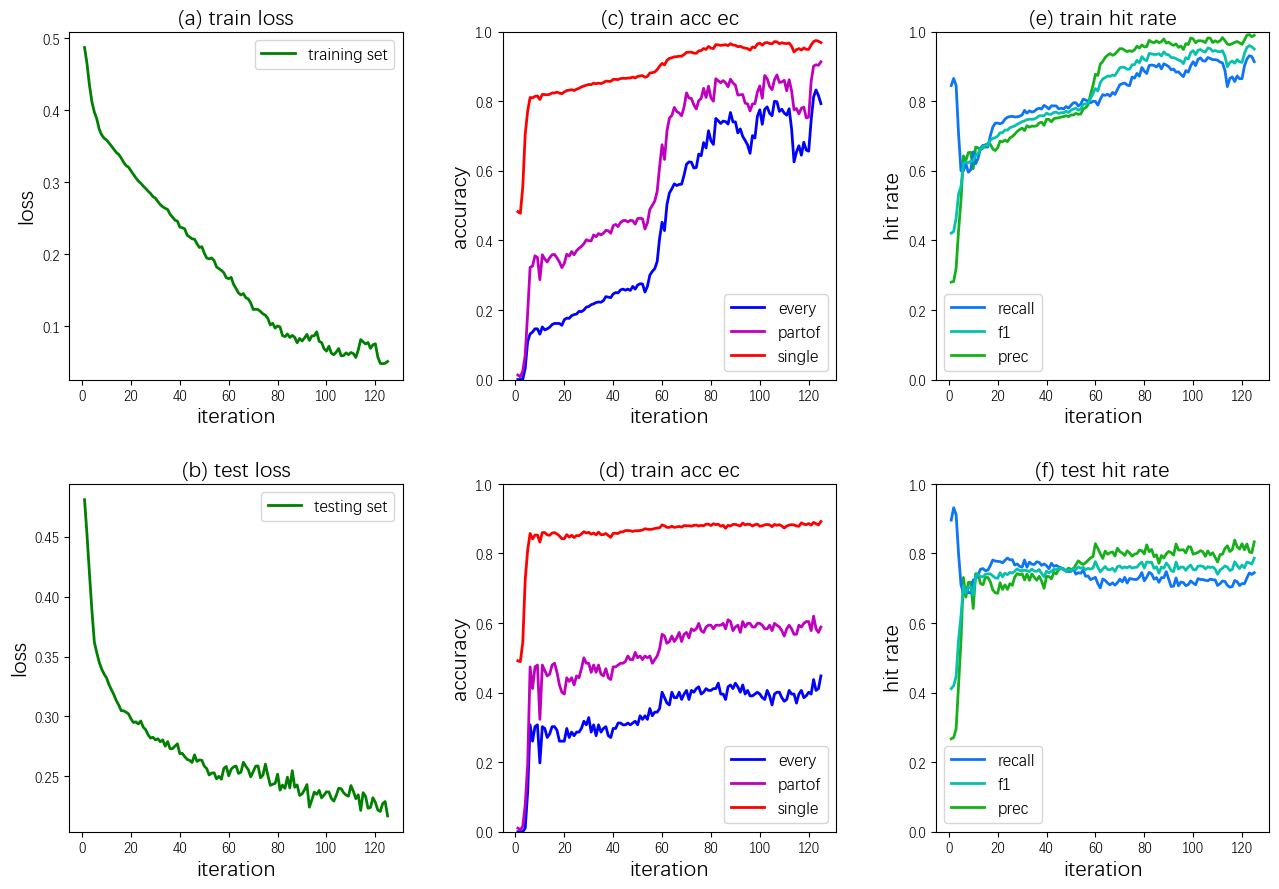

In [22]:
x_range = list(range(1, len(tra_ec_loss) + 1))
fig = plt.figure(num=1, figsize=(15, 10), dpi=100, clear=True)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=0.3, wspace=0.3)
ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 4)
ax3 = fig.add_subplot(2, 3, 2)
ax4 = fig.add_subplot(2, 3, 5)
ax5 = fig.add_subplot(2, 3, 3)
ax6 = fig.add_subplot(2, 3, 6)

l1, = ax1.plot(x_range, tra_ec_loss, c='g', lw='2')
ax1.set_title('(a) train loss', fontsize=16)
ax1.set_xlabel('iteration', fontsize=16)
ax1.set_ylabel('loss', fontsize=16)
ax1.legend([l1, ], ['training set'], fontsize=12)  

l1,  = ax2.plot(x_range, tes_ec_loss, c='g', lw='2')
ax2.set_title('(b) test loss', fontsize=16)
ax2.set_xlabel('iteration', fontsize=16)
ax2.set_ylabel('loss', fontsize=16)
ax2.legend([l1, ], ['testing set'], fontsize=12)  

l1,  = ax3.plot(x_range, tra_ec_acc1, c='b', lw='2')
l2,  = ax3.plot(x_range, tra_ec_acc2, c='m', lw='2')
l3,  = ax3.plot(x_range, tra_ec_acc3, c='r', lw='2')
ax3.set_title('(c) train acc ec', fontsize=16)
ax3.set_xlabel('iteration', fontsize=16)
ax3.set_ylabel('accuracy', fontsize=16)
ax3.set_ylim((0, 1))
ax3.legend([l1, l2, l3], ['every', 'partof', 'single'], loc='lower right', fontsize=12)  

l1,  = ax4.plot(x_range, tes_ec_acc1, c='b', lw='2')
l2,  = ax4.plot(x_range, tes_ec_acc2, c='m', lw='2')
l3,  = ax4.plot(x_range, tes_ec_acc3, c='r', lw='2')
ax4.set_title('(d) train acc ec', fontsize=16)
ax4.set_xlabel('iteration', fontsize=16)
ax4.set_ylabel('accuracy', fontsize=16)
ax4.set_ylim((0, 1))
ax4.legend([l1, l2, l3], ['every', 'partof', 'single'], loc='lower right', fontsize=12)  

l1,  = ax5.plot(x_range, tra_ec_hit1, c=seaborn.xkcd_rgb['green'], lw='2')
l2,  = ax5.plot(x_range, tra_ec_hit2, c=seaborn.xkcd_rgb['deep sky blue'], lw='2')
l3,  = ax5.plot(x_range, tra_ec_hit3, c=seaborn.xkcd_rgb['turquoise'], lw='2')
ax5.set_title('(e) train hit rate', fontsize=16)
ax5.set_xlabel('iteration', fontsize=16)
ax5.set_ylabel('hit rate', fontsize=16)
ax5.set_ylim((0, 1))
ax5.legend([l2, l3, l1], ['recall', 'f1', 'prec'], loc='lower left', fontsize=12)  

l1,  = ax6.plot(x_range, tes_ec_hit1, c=seaborn.xkcd_rgb['green'], lw='2')
l2,  = ax6.plot(x_range, tes_ec_hit2, c=seaborn.xkcd_rgb['deep sky blue'], lw='2')
l3,  = ax6.plot(x_range, tes_ec_hit3, c=seaborn.xkcd_rgb['turquoise'], lw='2')
ax6.set_title('(f) test hit rate', fontsize=16)
ax6.set_xlabel('iteration', fontsize=16)
ax6.set_ylabel('hit rate', fontsize=16)
ax6.set_ylim((0, 1))
ax6.legend([l2, l3, l1], ['recall', 'f1', 'prec'], loc='lower left', fontsize=12)  

plt.savefig('./results/ec_pre_partial.jpg')

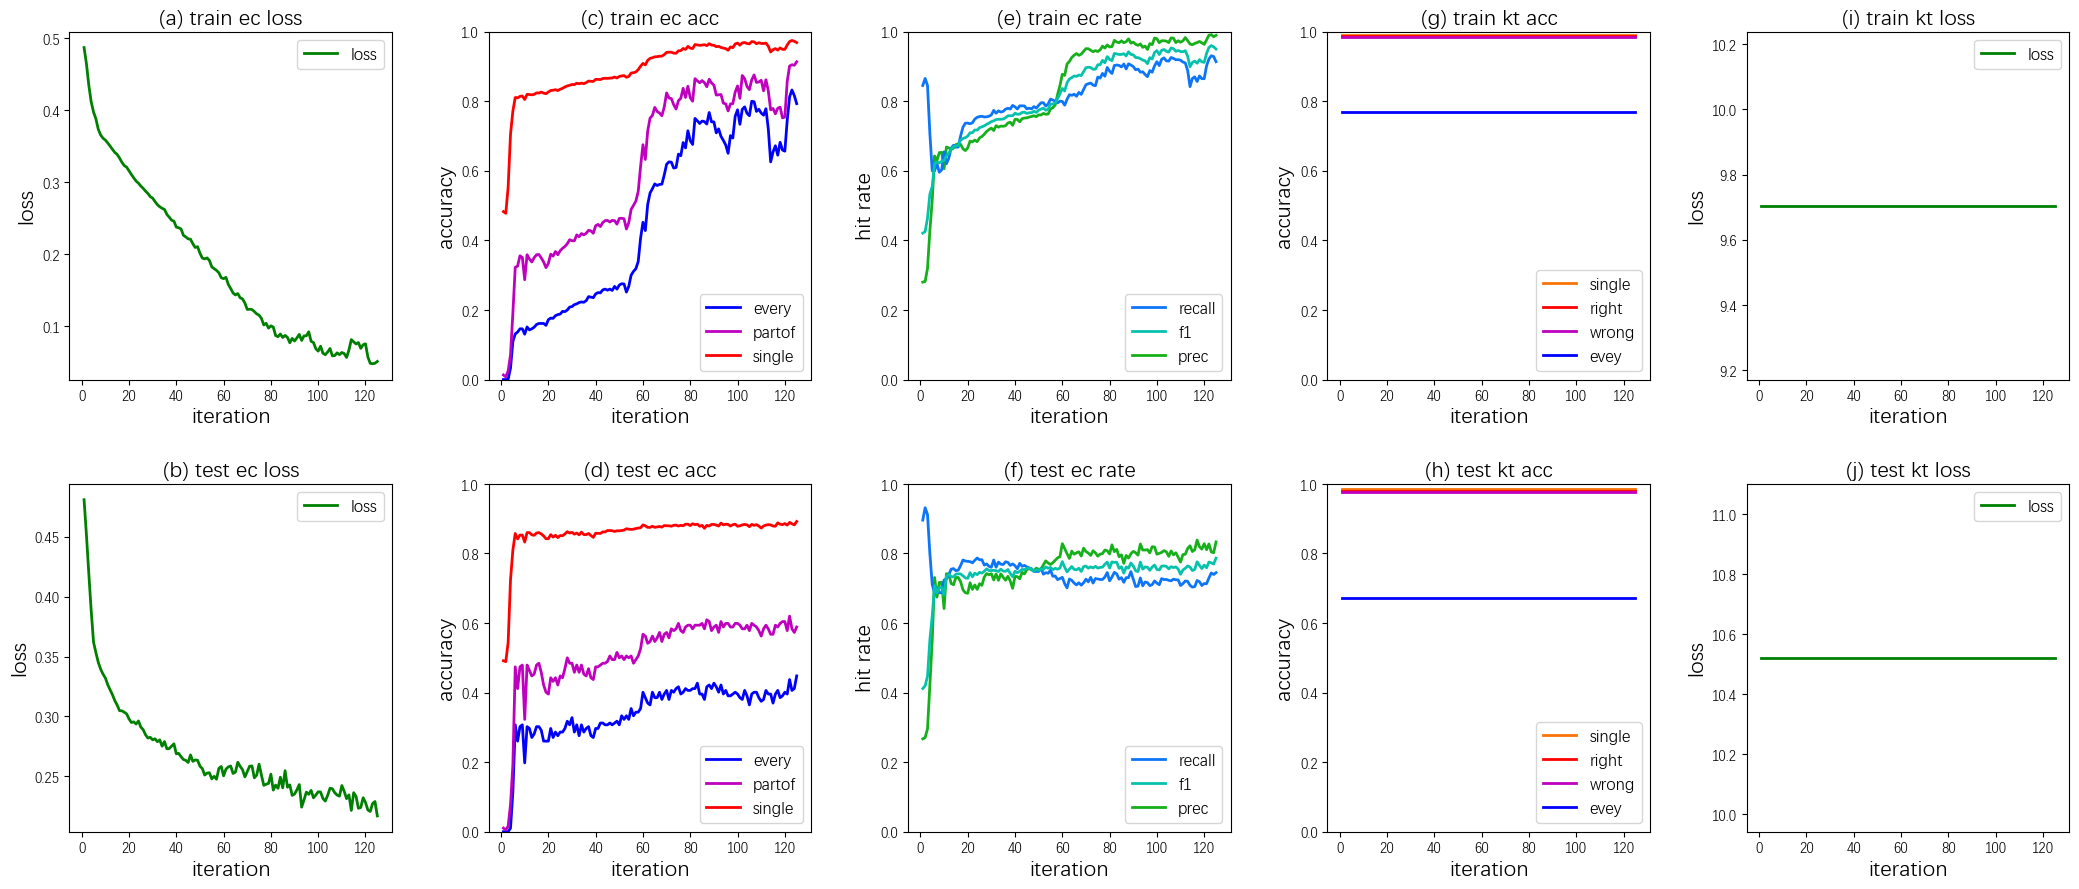

In [23]:
x_range = list(range(1, len(tra_ec_loss) + 1))
fig = plt.figure(num=1, figsize=(25, 10), dpi=100, clear=True)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=0.3, wspace=0.3)
ax1 = fig.add_subplot(2, 5, 1)
ax2 = fig.add_subplot(2, 5, 6)
ax3 = fig.add_subplot(2, 5, 2)
ax4 = fig.add_subplot(2, 5, 7)
ax5 = fig.add_subplot(2, 5, 3)
ax6 = fig.add_subplot(2, 5, 8)
ax7 = fig.add_subplot(2, 5, 4)
ax8 = fig.add_subplot(2, 5, 9)
ax9 = fig.add_subplot(2, 5, 5)
ax0 = fig.add_subplot(2, 5, 10)

l1, = ax1.plot(x_range, tra_ec_loss, c='g', lw='2')
ax1.set_title('(a) train ec loss', fontsize=16)
ax1.set_xlabel('iteration', fontsize=16)
ax1.set_ylabel('loss', fontsize=16)
ax1.legend([l1, ], ['loss'], loc='upper right', fontsize=12)  

l1, = ax2.plot(x_range, tes_ec_loss, c='g', lw='2')
ax2.set_title('(b) test ec loss', fontsize=16)
ax2.set_xlabel('iteration', fontsize=16)
ax2.set_ylabel('loss', fontsize=16)
ax2.legend([l1, ], ['loss', ], loc='upper right', fontsize=12)  

l1,  = ax3.plot(x_range, tra_ec_acc1, c='b', lw='2')
l2,  = ax3.plot(x_range, tra_ec_acc2, c='m', lw='2')
l3,  = ax3.plot(x_range, tra_ec_acc3, c='r', lw='2')
ax3.set_title('(c) train ec acc', fontsize=16)
ax3.set_xlabel('iteration', fontsize=16)
ax3.set_ylabel('accuracy', fontsize=16)
ax3.set_ylim((0, 1))
ax3.legend([l1, l2, l3], ['every', 'partof', 'single'], loc='lower right', fontsize=12)  

l1,  = ax4.plot(x_range, tes_ec_acc1, c='b', lw='2')
l2,  = ax4.plot(x_range, tes_ec_acc2, c='m', lw='2')
l3,  = ax4.plot(x_range, tes_ec_acc3, c='r', lw='2')
ax4.set_title('(d) test ec acc', fontsize=16)
ax4.set_xlabel('iteration', fontsize=16)
ax4.set_ylabel('accuracy', fontsize=16)
ax4.set_ylim((0, 1))
ax4.legend([l1, l2, l3], ['every', 'partof', 'single'], loc='lower right', fontsize=12)  

l1,  = ax5.plot(x_range, tra_ec_hit1, c=seaborn.xkcd_rgb['green'], lw='2')
l2,  = ax5.plot(x_range, tra_ec_hit2, c=seaborn.xkcd_rgb['deep sky blue'], lw='2')
l3,  = ax5.plot(x_range, tra_ec_hit3, c=seaborn.xkcd_rgb['turquoise'], lw='2')
ax5.set_title('(e) train ec rate', fontsize=16)
ax5.set_xlabel('iteration', fontsize=16)
ax5.set_ylabel('hit rate', fontsize=16)
ax5.set_ylim((0, 1))
ax5.legend([l2, l3, l1], ['recall', 'f1', 'prec'], loc='lower right', fontsize=12)  

l1,  = ax6.plot(x_range, tes_ec_hit1, c=seaborn.xkcd_rgb['green'], lw='2')
l2,  = ax6.plot(x_range, tes_ec_hit2, c=seaborn.xkcd_rgb['deep sky blue'], lw='2')
l3,  = ax6.plot(x_range, tes_ec_hit3, c=seaborn.xkcd_rgb['turquoise'], lw='2')
ax6.set_title('(f) test ec rate', fontsize=16)
ax6.set_xlabel('iteration', fontsize=16)
ax6.set_ylabel('hit rate', fontsize=16)
ax6.set_ylim((0, 1))
ax6.legend([l2, l3, l1], ['recall', 'f1', 'prec'], loc='lower right', fontsize=12)  

l1, = ax9.plot(x_range, tra_kt_loss, c='g', lw='2')
ax9.set_title('(i) train kt loss', fontsize=16)
ax9.set_xlabel('iteration', fontsize=16)
ax9.set_ylabel('loss', fontsize=16)
ax9.legend([l1, ], ['loss'], loc='upper right', fontsize=12)  

l1, = ax0.plot(x_range, tes_kt_loss, c='g', lw='2')
ax0.set_title('(j) test kt loss', fontsize=16)
ax0.set_xlabel('iteration', fontsize=16)
ax0.set_ylabel('loss', fontsize=16)
ax0.legend([l1, ], ['loss', ], loc='upper right', fontsize=12)  

l1, = ax7.plot(x_range, tra_kt_acc1, c=seaborn.xkcd_rgb['orange'], lw='2')
l2, = ax7.plot(x_range, tra_kt_acc3, c='r', lw='2')
l3, = ax7.plot(x_range, tra_kt_acc4, c='m', lw='2')
l4, = ax7.plot(x_range, tra_kt_acc2, c='b', lw='2')
ax7.set_title('(g) train kt acc', fontsize=16)
ax7.set_xlabel('iteration', fontsize=16)
ax7.set_ylabel('accuracy', fontsize=16)
ax7.set_ylim((0, 1))
ax7.legend([l1, l2, l3, l4], ['single', 'right', 'wrong', 'evey'], loc='lower right', fontsize=12)  

l1, = ax8.plot(x_range, tes_kt_acc1, c=seaborn.xkcd_rgb['orange'], lw='2')
l2, = ax8.plot(x_range, tes_kt_acc3, c='r', lw='2')
l3, = ax8.plot(x_range, tes_kt_acc4, c='m', lw='2')
l4, = ax8.plot(x_range, tes_kt_acc2, c='b', lw='2')
ax8.set_title('(h) test kt acc', fontsize=16)
ax8.set_xlabel('iteration', fontsize=16)
ax8.set_ylabel('accuracy', fontsize=16)
ax8.set_ylim((0, 1))
ax8.legend([l1, l2, l3, l4], ['single', 'right', 'wrong', 'evey'], loc='lower right', fontsize=12)  

plt.savefig('./results/ec_pre_total.jpg')